# How did road freight transport develop in the Netherlands?


## Section 1: Business Understanding

I spent hours daily driving on one of the busiest motorways in the Netherlands , when commuting was still a norm. When I first came across with the goods vehicle data on CBS website, it immediately attracted my attention: it could answer those not so important questions that I have always had, when stuck in a traffic jam after a long day of work, alongside the lorries.

- What are the types of common goods vehicle? How can we tell them apart using data?
- What is the lifespan of a goods vehicle?
- Why is there such high volume of goods vehicle on the motorways nowadays?


## Section 2: Data Understanding

In this notebook I used two data to expolore the freights transport develop in the last decades. <br/>

- Vehicle kilometres is retrieve from Centraal Bureau voor de Statistiek [goods_vehicles_link](https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=84651ENG&_theme=1111)<br/>
- GDP data is downloaded from World Bank: [gdp_link](https://data.worldbank.org/country/netherlands)


In [1]:
import cbsodata
from pathlib import Path
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

sns.set_palette("husl")

## Section 2.1: Goods Vehicle Kilometres data

As per information on cbs webiste, the data contains information on total vehicle kilometres of goods vehicles in the Netherlands (broken down by Dutch and foreign vehicles) and data of total kilometres and average annual kilometres of Dutch goods vehicles (broken down by Dutch and foreign territory). All figures are further broken down by lorries and road tractors, by age of the vehicle and by load capacity.  The data is available for the period from 2001 to 2018.

In [2]:
df = pd.DataFrame(cbsodata.get_data('84651ENG')) # Downloading table list from cbs portal
metadata_data_properties = pd.DataFrame(cbsodata.get_meta('84651ENG', 'DataProperties')) # Downloading metadata

In [3]:
df.head(2)

,ID,LorriesAndRoadTractors,YearsOfConstruction,Periods,TotalKilometresInTheNetherlands_1,KilometresByDutchVehicles_2,KilometresByForeignVehicles_3,TotalKilometresByDutchVehicles_4,KilometresInTheNetherlands_5,KilometresAbroad_6,TotalAverageAnnualKilometres_7,AverageAnnualKilometresInNetherlands_8,AverageAnnualKilometresAbroad_9,DutchGoodsVehiclesInUse_10
0,0,Lorries and road tractors,Total of all construction years,2001,6592.1,6014.7,577.5,9869.7,6014.7,3855.1,58913.0,35902.0,23011.0,167530.0
1,1,Lorries and road tractors,Total of all construction years,2002,6600.8,5999.6,601.1,9973.7,5999.6,3974.1,59846.0,36000.0,23846.0,166657.0


### Section 2.2: GDP data

We will first import the data downloaded from the world bank website and explore the available information. 



In [4]:
# Import world bank data, and wrangle the data set
df_gdp = pd.read_csv('./data/API_NLD_DS2_en_csv_v2_1224624.csv', skiprows=4, delimiter=',')

In [5]:
df_gdp.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Netherlands,NLD,High-technology exports (current US$),TX.VAL.TECH.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.496821e+10,8.160815e+10,8.788562e+10,9.109705e+10,6.986617e+10,7.115146e+10,7.819285e+10,8.569057e+10,NaN,NaN
1,Netherlands,NLD,Merchandise exports to economies in the Arab W...,TX.VAL.MRCH.AL.ZS,2.724231,2.268511,2.447537,2.097775,1.869094,1.88323,...,1.975527e+00,2.361828e+00,2.468941e+00,2.614767e+00,2.584888e+00,2.324295e+00,2.271216e+00,2.368265e+00,NaN,NaN


Economic data is provided using various indicators. Without further investigating the terminologies or testing which is the most appropriate, we will use 'GDP (current US$)' as the indictor for the subsequent analysis.  The data is available for the duration from 1960 to 2019.

## Section 3:  Preparing Data

### Section 3.1 GDP 

For GDP, we will make use of the row 'GDP (current US$)' only. we will first drop the non-relevant data and prepare to make it ready for analysis. 

In [6]:
# Data wrangling for gdp data
df_gdp = df_gdp[df_gdp['Indicator Name'] == 'GDP (current US$)'] # Use GDP (current US$) only, the rest information are not of interest atm
df_gdp = df_gdp.transpose()

df_gdp = df_gdp[df_gdp.applymap(np.isreal)] # Drop the non-numeric values
df_gdp.dropna(inplace=True) # drop NaN
df_gdp.reset_index(inplace=True)
df_gdp.columns = ['Periods','GDP (current US$)'] 

# Convert the data type to 
df_gdp['Periods'] = df_gdp['Periods'].astype('int');
df_gdp['GDP (current US$)']= df_gdp['GDP (current US$)'].astype('float');

# Select a subset for the period 2005 -2018
df_gdp = df_gdp.loc[(df_gdp['Periods']>=2005) & (df_gdp['Periods']<=2018) ]

### Section 3.2 CBS data 

#### pre-processing categorical data 

In [7]:
cat_col = df.columns[df.dtypes == 'object']
df[cat_col].describe()

,LorriesAndRoadTractors,YearsOfConstruction,Periods
count,1836,1836,1836
unique,6,17,18
top,20 000 kg or more,Year of construction 2000 to 2005,2016
freq,306,108,102


The dataset contains three types of categorical data. We will explore each in turns:

#####  lorries and road tracoter

In [8]:
# Read metadata
pd.DataFrame(cbsodata.get_meta('84651ENG', 'LorriesAndRoadTractors'))

,Key,Title,Description,CategoryGroupID
0,A018938,Lorries and road tractors,Lorry\r\nRigid heavy goods road vehicle with a...,None
1,A018937,Road tractor,"Road motor vehicle, exclusively or primarily d...",None
2,A018936,Lorry (road tractor not included),Rigid heavy goods road vehicle with a gross ve...,None
3,A028272,To 10 000 kg,The total weight of the vehicle (or combinatio...,None
4,A028273,10 000 to 20 000 kg,The total weight of the vehicle (or combinatio...,None
5,A028274,20 000 kg or more,The total weight of the vehicle (or combinatio...,None


In [9]:
df_goupby_vechile_type = df.groupby(['LorriesAndRoadTractors']).sum()['DutchGoodsVehiclesInUse_10']

In [10]:
df_goupby_vechile_type

LorriesAndRoadTractors
10 000 to 20 000 kg                  1295550.0
20 000 kg or more                     987069.0
Lorries and road tractors            5914882.0
Lorry (road tractor not included)    2936908.0
Road tractor                         2977974.0
To 10 000 kg                          654290.0
Name: DutchGoodsVehiclesInUse_10, dtype: float64

Obviously 'Lorries and road tractors' is the summation of 'Road tractor' and 'Lorry (road tractor not included)'. to avoid double-counting the values, it is decided to drop the rows where the vehicle type is 'Lorries and road tractors'

'To 10 000 kg' and '10 t to 20 t', '20 t' are sub-cat of the tractor types. it is decided to drop those rows as well.

In [11]:
# Drop subgroups as described above
cols = ['Lorries and road tractors', 'To 10 000 kg', '10 000 to 20 000 kg', '20 000 kg or more']
for col in cols:
    df.drop(df[df['LorriesAndRoadTractors'] == col].index, axis=0, inplace=True)

In [12]:
# Rename the columns
df['LorriesAndRoadTractors'].replace({'Lorry (road tractor not included)':"Lorry"}, inplace = True)

##### Years Of Construction

In [13]:
# Drop the row that summarizes Total of all construction years
df = df.drop(df.loc[df["YearsOfConstruction"] == 'Total of all construction years'].index)

####  Numerical data

In [14]:
if 'ID' in df.columns:
    df = df.drop(['ID'], axis=1)

In [15]:
df.nunique(axis=0)
df.describe().apply(lambda s: s.apply(lambda x: format(x, '0.1f')))

,TotalKilometresInTheNetherlands_1,KilometresByDutchVehicles_2,KilometresByForeignVehicles_3,TotalKilometresByDutchVehicles_4,KilometresInTheNetherlands_5,KilometresAbroad_6,TotalAverageAnnualKilometres_7,AverageAnnualKilometresInNetherlands_8,AverageAnnualKilometresAbroad_9,DutchGoodsVehiclesInUse_10
count,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0,282.0
mean,445.2,398.9,46.3,626.6,398.9,227.7,61416.4,40537.8,20878.6,10487.4
std,472.6,423.8,59.4,741.4,423.8,352.7,28600.6,14950.1,15962.4,11809.8
min,21.7,19.7,2.0,26.3,19.7,6.7,5368.0,4743.0,625.0,1742.0
25%,174.1,160.2,11.5,208.1,160.2,46.3,40891.5,29358.5,9374.8,4245.5
50%,277.1,242.9,19.6,355.5,242.9,88.0,59441.0,43855.5,15084.0,6278.0
75%,526.6,462.6,65.5,774.3,462.6,287.4,83278.8,51050.5,32021.5,10414.5
max,2611.0,2492.8,387.6,4481.4,2492.8,2401.1,122680.0,73155.0,73608.0,81535.0


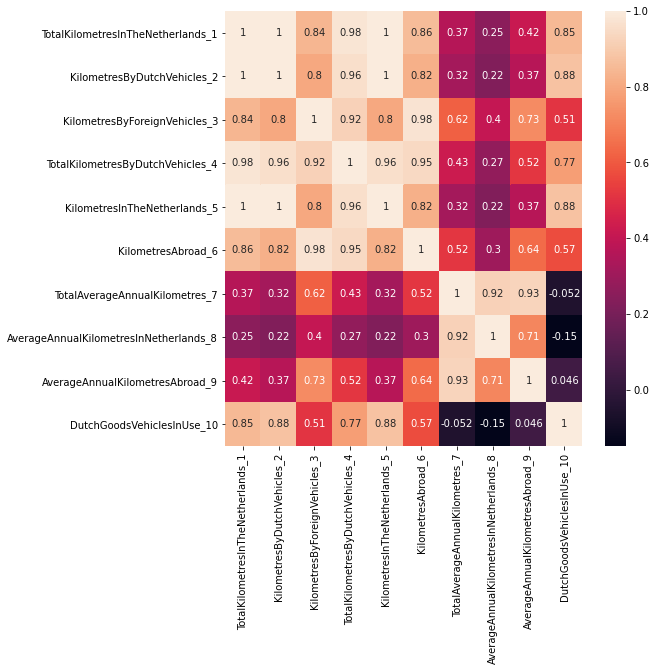

In [16]:
# Establish the correlation matrix
corr = df.corr()
fig, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True)

quite some information is highly correlated. therefore it is decided to keep only the most relavent columns

In [17]:
# drop the highly correlated items
# to-do: write a function to identify the columns to keep based on values in the correlation matrix
to_keep = ['LorriesAndRoadTractors', 
        'YearsOfConstruction', 
        'Periods',
        'KilometresByDutchVehicles_2',
        'KilometresByForeignVehicles_3',
        'KilometresInTheNetherlands_5',  
        'KilometresAbroad_6',
        'DutchGoodsVehiclesInUse_10'] 

In [18]:
df = df[to_keep].copy()

We would like to see if there is any outlier, wrong data included in the dataset, and assign NAN with a reasonable value

In [19]:
df.isna().sum()/df.shape[0]  # Calcuate the perctentage of NaNs

LorriesAndRoadTractors           0.000000
YearsOfConstruction              0.000000
Periods                          0.000000
KilometresByDutchVehicles_2      0.510417
KilometresByForeignVehicles_3    0.510417
KilometresInTheNetherlands_5     0.510417
KilometresAbroad_6               0.510417
DutchGoodsVehiclesInUse_10       0.510417
dtype: float64

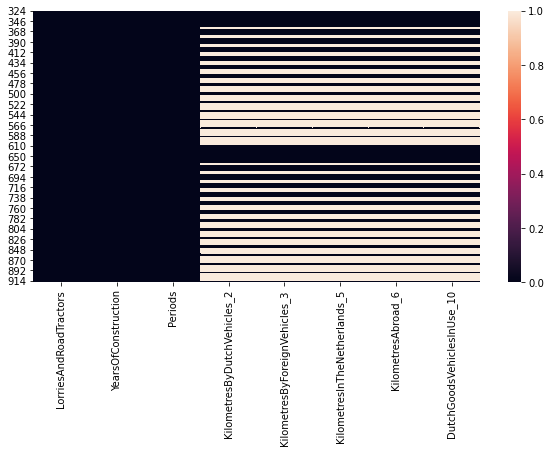

In [20]:
# visualzie NaN and its locations within the df
fig, ax = plt.subplots(figsize = (10, 5))
sns.heatmap(df.isnull())
plt.show()

Quite some data is missing. Seen from the heatmap above, NaN purely because the data is not avaiable for the correspoind (years of contruction, periods) combinataion

In [21]:
df.dropna(inplace=True)

## Section 4: Evaluate the Results

With data wrangling completed, we would like to further analyze the data, and prepare the visualizations. 

 ### Q1: What are the types of common goods vehicle? How can we tell them apart using data?

In [22]:
df_type =  df.groupby(['Periods',"LorriesAndRoadTractors"]).sum() 
df_type.reset_index(inplace=True)  # Flatten the dataframe

In [23]:
df_type['LorriesAndRoadTractors'].unique()

array(['Lorry', 'Road tractor'], dtype=object)

During the data wrangling, we already drpped the subgroups in the vechile type categaory. Hence the current dataframe contains information fro only 'Lorry', 'Road tractor'. With this done, we would like to see how 'Lorry' and 'Road tractor' differ and how can we tell them apart using the availalbe data. 

In [24]:
def bar_plot(data, y, y_label):
    """ Bar plot to present the variation over the years
    
    Args:
    data: dataframe. The dataframe containing vehicle km
    y: str. Column name in the dataframe to present in the bar plot
    y_label: str. Label for y axis in the bar plot
    
    Returns:
    fig, ax of the figs 
    """
    fig, ax = plt.subplots(figsize = (15, 5))
    
    try:
        sns.barplot(x= "Periods", y= y, hue= "LorriesAndRoadTractors",  data= data, ax = ax)  # x, hue are hard coded
    except:
        raise Exception('the data does not contain the specified column, or either "Periods" or "LorriesAndRoadTractors" not in the data')
        
    ax.set_ylabel (y_label)
    fig.savefig('./image/{:}.png'.format(y_label.replace(' ', '_')), bbox_inches = 'tight',dpi=150)
    
    return fig, ax

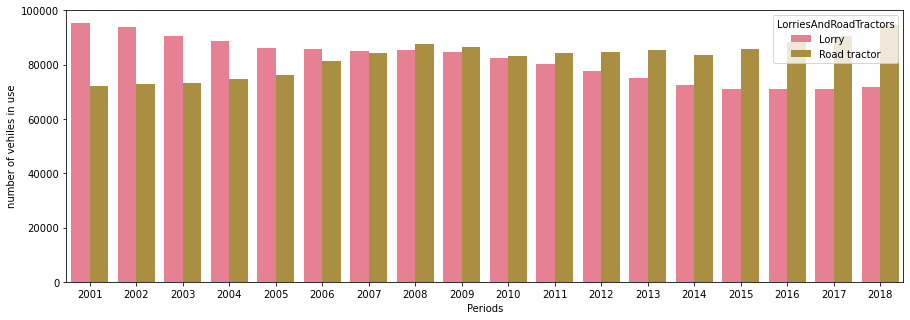

In [25]:
# Present the variation of total number of registered vehicles over the years
fig, ax = bar_plot(data = df_type, y="DutchGoodsVehiclesInUse_10", y_label='number of vehiles in use')

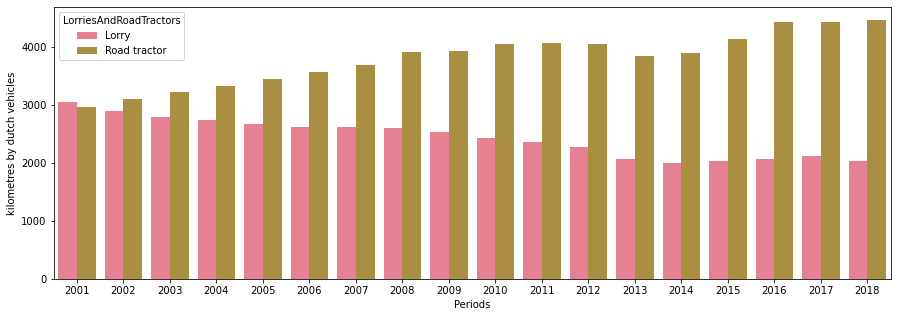

In [26]:
# Present the variation of total number of vehicles kilometres over the years
fig, ax = bar_plot(data = df_type, y="KilometresByDutchVehicles_2", y_label='kilometres by dutch vehicles')

From the charts above, it can be concluded that road tractor is gradually gaining popularity as of 2001. Road tractor total kilometres outnumber lorries in 2002. The registered amount of road tractor outnumbered lorries in 2008. In 2018, road tractor kilometres was already more than twice that of the lorry.

#### annual average kilometer in NL and abroad

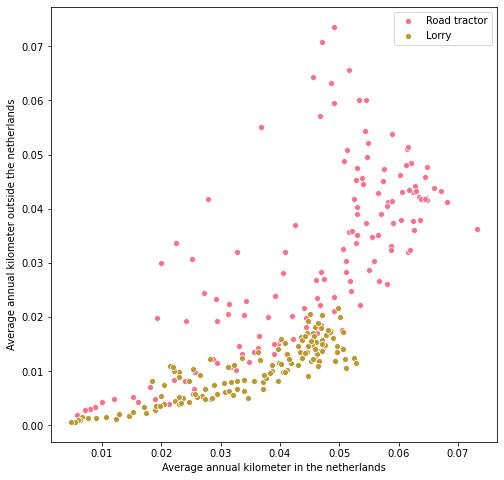

In [27]:
# Use a scatter plot to present the annual a verage within NL vs outside NL. 

fig, ax = plt.subplots(figsize = (8, 8))

for lorries in df['LorriesAndRoadTractors'].unique():
    
    idx = df['LorriesAndRoadTractors'] == lorries  # identify the rows with the type of either lorry or road tractor
    x = df.loc[idx]['KilometresInTheNetherlands_5']/df.loc[idx]['DutchGoodsVehiclesInUse_10'] # Determine the average annual distance in NL
    y = df.loc[idx]['KilometresAbroad_6']/df.loc[idx]['DutchGoodsVehiclesInUse_10'] # Determine the average annual distance outside NL
    
    sns.scatterplot( x = x , y = y, label = lorries)
    
ax.set_xlabel('Average annual kilometer in the netherlands')
ax.set_ylabel('Average annual kilometer outside the netherlands')
fig.savefig('./image/average_annual_kilometer_by_dutch_vehicles.png', bbox_inches = 'tight')

The figure above compares the average annual kilometres in and outside the Netherlands, for lorries and road tractors. From the figure above, it is observed that:

- Road tractors are more involved in extra-territory transportation than lorries;
- Road tractors tend to have larger annual kilometres than the lorries, both in and outside the Netherlands.

### Q2: What is the lifespan of a goods vehicle?

In this section, we will explore the lifespan of goods vehicle. Instead of directly answering it, we will tweak this question slightly and investigate how long it takes for half of the newly constructed to become de-registered. To achieve this, we need to first further process the data to 

1. include an additional column named [YearInService]
2. calculate the percentage of cars remain in serive

In [28]:
# First drop row with non-numerical values
df_years_in_service =  df.drop(df.loc[(df["YearsOfConstruction"] ==
                                      'Year of construction 1900 to 2000') | 
                                       (df["YearsOfConstruction"] ==
                                      'Year of construction 2000 to 2005')].index).copy()

In [29]:
# determine the years in service based on colum Periods and YearsOfConstruction
df_years_in_service['YearsInService'] = df_years_in_service['Periods'].astype('int') - df_years_in_service['YearsOfConstruction'].astype('int') 

In [30]:
# Prepare a new dataframe that summarize the number of annual new construction 
df_yearly_new_construction = df_years_in_service[df_years_in_service['YearsInService'] == 0].copy()
df_yearly_new_construction['yearly_new_construction'] = df_yearly_new_construction['DutchGoodsVehiclesInUse_10']

In [31]:
# In clude only the columns of the most interest
df_yearly_new_construction = df_yearly_new_construction[['LorriesAndRoadTractors','YearsOfConstruction','yearly_new_construction']]

In [32]:
# inlude column ''yearly_new_construction' in the df_years_in_service, in order to determine the % remain in use
df_years_in_service = pd.merge(df_years_in_service, df_yearly_new_construction,
         on = ['LorriesAndRoadTractors','YearsOfConstruction']) 

# determine the percentage of vehicle reamain in use after certain years
df_years_in_service['DutchGoodsVehiclesInUse_%'] = 100*df_years_in_service['DutchGoodsVehiclesInUse_10']/df_years_in_service['yearly_new_construction']

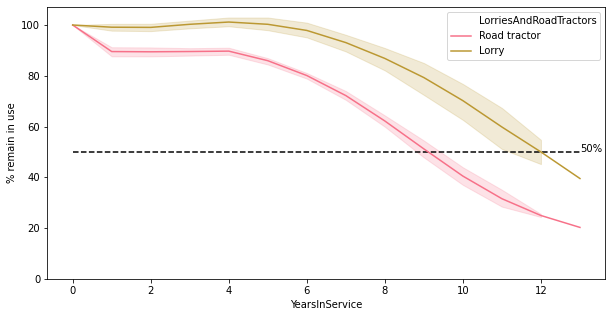

In [33]:
# Visualize the relation bettwen % of vehicle (in y) remain in service, after X years (in x)

fig, ax = plt.subplots(figsize = (10, 5))

ax = sns.lineplot(x="YearsInService", y="DutchGoodsVehiclesInUse_%", 
                  hue="LorriesAndRoadTractors",
                  data=df_years_in_service)

ax.set_ylabel('% remain in use')
ax.set_ylim(bottom = 0.0)
ax.hlines(50, 0, 13, linestyle = 'dashed')
ax.annotate('50%', (13,50))

fig.savefig('./image/years_in_service.png', bbox_inches = 'tight')

The figure above presents the percentage of the goods vehicle that remains in use, to the number of years in service. 

A clear distinction can be made between lorry and road tractor: 50% of the newly constructed road tractors become de-registered after being in use for 9 years; for lorries, that occurs 3 years later when they are in use for 12 years.

### Q3 Why so many goods vehicles nowadays?

I always hear “it is a sign of booming economy” when talking to my Dutch fellows about the over crowded motorways. With this in mind, I examined the vehicle data, in combination with GDP records from the World Bank.

In [34]:
# Group the vehicle data, to determine the annual vehicle kilometres
df_yearly =  df.groupby(['Periods']).sum()
df_yearly.reset_index(inplace=True)

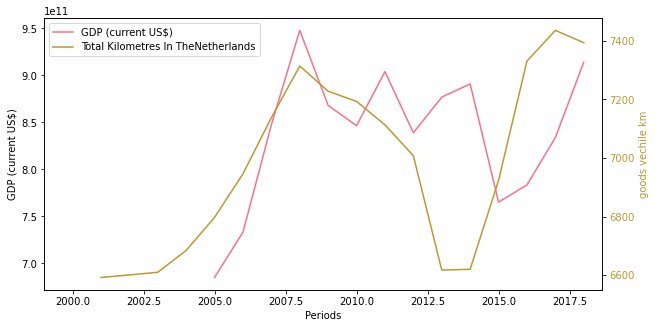

In [35]:
# Viusalize vehicle kilometres and gdp in one chart 

# plot gdp
ax = df_gdp.plot(x = 'Periods', y = 'GDP (current US$)', figsize = (10, 5))
ax.set_ylabel('GDP (current US$)')
ax.set_xlim(left = 1999)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = sns.color_palette()[1]
ax2.set_ylabel('goods vechile km', color = color) 
ax2.tick_params(axis='y', labelcolor = color)

# plot vehicle km
ax2.plot(df_yearly.Periods.astype('int').values, 
         df_yearly.KilometresByDutchVehicles_2 + df_yearly.KilometresByForeignVehicles_3, 
         color = color, label = 'Total Kilometres In TheNetherlands')

# set the legengds in one box
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')
plt.savefig('./image/vehicle_km_gdp.png', bbox_inches = 'tight')

The chart above presents GPD (current USD)and goods vehicle km over the period from 2001 to 2018. A few observations can be made:

- Vehicle km is highly correlated to economic growth: it increases during the economic boom and shrinks in the bust.
- Road transport seems to lead the cycle. While freight transport recovery started in 2014, the economy entered the growth cycle one year later in 2015. Similarly, the traffic kilometers reached its peak one year earlier in 2017 while the economy peaked in 2018.

Will the economy also influence new investment on goods vehicles? With this in mind, we will further examine the yearly new construction with GDP

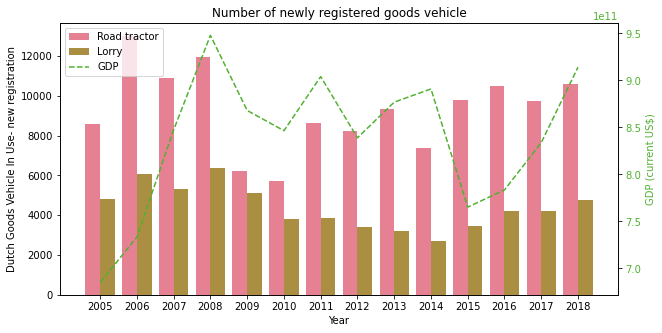

In [36]:
df_yearly_new_construction['YearsOfConstruction'] = df_yearly_new_construction['YearsOfConstruction'].astype('int')  # convert data type

# Visualize the data
fig, ax = plt.subplots(figsize = (10, 5))

ax = sns.barplot(x="YearsOfConstruction", y="yearly_new_construction", 
                  hue="LorriesAndRoadTractors",
                  data=df_yearly_new_construction)

ax.set_title('Number of newly registered goods vehicle');
ax.set_ylabel('Dutch Goods Vehicle In Use- new registration')
ax.set_xlabel('Year')

# Include GDP
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = sns.color_palette()[2]
ax2.plot(ax.get_xticks(), df_gdp['GDP (current US$)'], color = color, label = 'GDP', linestyle = '--')
ax2.set_ylabel('GDP (current US$)', color = color)
ax2.tick_params(axis='y', labelcolor = color)

# Inlcude lengends in on box
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')
plt.savefig('./image/new_registration_v_gdp.png', bbox_inches = 'tight')

A similar trend can also be observed in the number of newly constructed or registered vehicles. During the years of 2009 and 2010, there is a significant reduction in the number of near construction. Investment in new vehicles started to recover from 2011 and returned to the pre-crisis level in 2015.